In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

## Dataset

In [85]:
def fetch_data():
    df = pd.read_csv("./spy_data.csv")
    data = pd.DataFrame()

    data['Call Option Price'] = df[' [C_LAST]']
    data['Call Volume'] = df[' [C_VOLUME]']
    data['Call Bid Price'] = df[' [C_BID]']
    data['Exercise Price'] = df[' [STRIKE]']
    data['Time to Expiration'] = df[' [DTE]']
    data['Volatility'] = df[' [C_IV]']

    return data

data = fetch_data()
data = data[data.columns].apply(pd.to_numeric, errors='coerce')
data = data.dropna()

/var/folders/y6/1d6nhf8n2hqfq_qz0hk_hpfr0000gn/T/ipykernel_99262/273038193.py:2: DtypeWarning: Columns (8,9,10,11,12,13,15,17,18,20,21,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./spy_data.csv")


# Results

In [66]:
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]
data['Call Option Price'] = np.sqrt(data['Call Option Price'])

print(data)

         Call Option Price  Call Volume  Call Bid Price  Exercise Price   
78                1.907878       2407.0            3.67           448.0  \
86                0.100000       6068.0            0.00           456.0   
87                0.100000       1528.0            0.00           457.0   
88                0.100000        272.0            0.00           458.0   
89                0.100000         71.0            0.00           459.0   
...                    ...          ...             ...             ...   
3588992           1.574802          2.0            1.41           570.0   
3588993           1.545962          1.0            1.30           575.0   
3588994           1.200000         40.0            1.12           580.0   
3588995           1.410674          1.0            0.94           585.0   
3588996           1.252996          3.0            1.35           590.0   

         Time to Expiration  Volatility  
78                      0.0     0.11477  
86             

In [86]:
X = data.drop('Call Option Price', axis=1)
y = data['Call Option Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       Call Option Price   Call Volume  Call Bid Price  Exercise Price   
count       2.751623e+06  2.751623e+06    2.751623e+06    2.751623e+06  \
mean        3.603422e+01  2.337627e+02    3.757331e+01    3.843756e+02   
std         5.097422e+01  3.121752e+03    5.348457e+01    1.007808e+02   
min         0.000000e+00  0.000000e+00    0.000000e+00    5.000000e+00   
25%         1.060000e+00  0.000000e+00    9.200000e-01    3.190000e+02   
50%         1.513000e+01  2.000000e+00    1.493000e+01    3.850000e+02   
75%         4.937000e+01  2.200000e+01    5.211000e+01    4.470000e+02   
max         4.442000e+02  3.818070e+05    4.441700e+02    7.200000e+02   

       Time to Expiration    Volatility  
count        2.751623e+06  2.751623e+06  
mean         1.688315e+02  3.067195e-01  
std          2.081567e+02  3.975514e-01  
min          0.000000e+00 -5.000000e-04  
25%          2.200000e+01  1.767800e-01  
50%          8.600000e+01  2.299100e-01  
75%          2.380400e+02  3.146800e-01

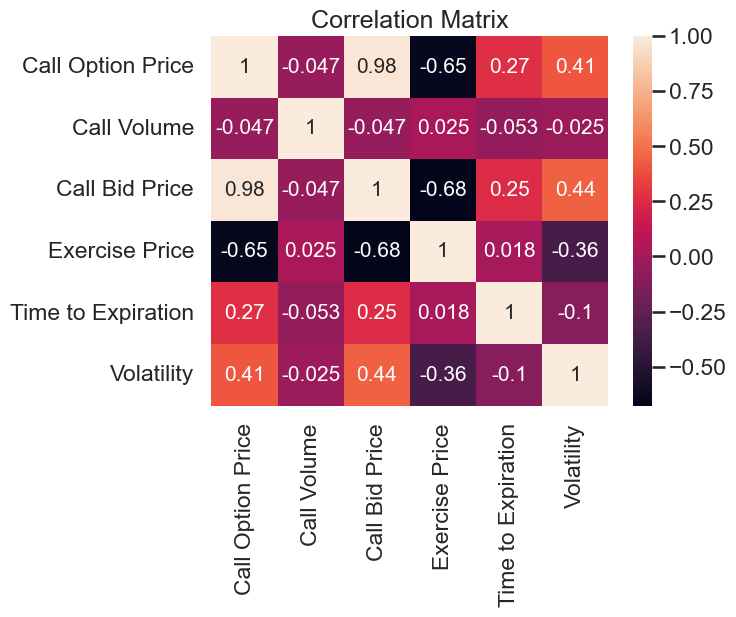

        VIF
0  1.009424
1  2.110387
2  2.021709
3  1.980734
4  2.062251


In [87]:
# Summary statistics
print(data.describe())

# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"size":15})
plt.title('Correlation Matrix')
plt.show()

# Check for collinearity
vif_data = pd.DataFrame() 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
print(vif_data)

In [88]:
vif_data["VIF"].mean()

1.8369009137371706

In [89]:
data_sample = data.sample(n=1000, random_state=1)

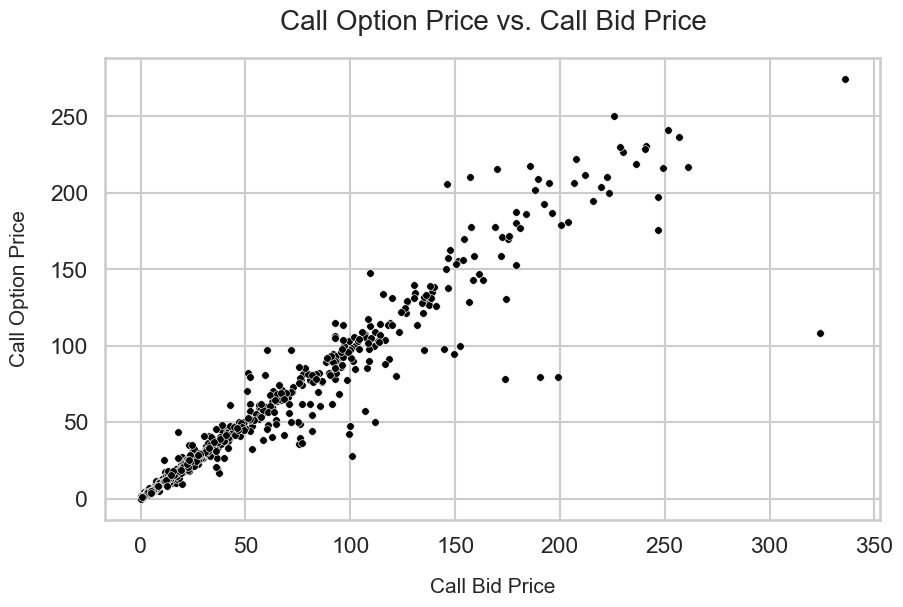

In [90]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Call Bid Price", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Call Bid Price', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Call Bid Price', fontsize=20, pad=20)
plt.show()

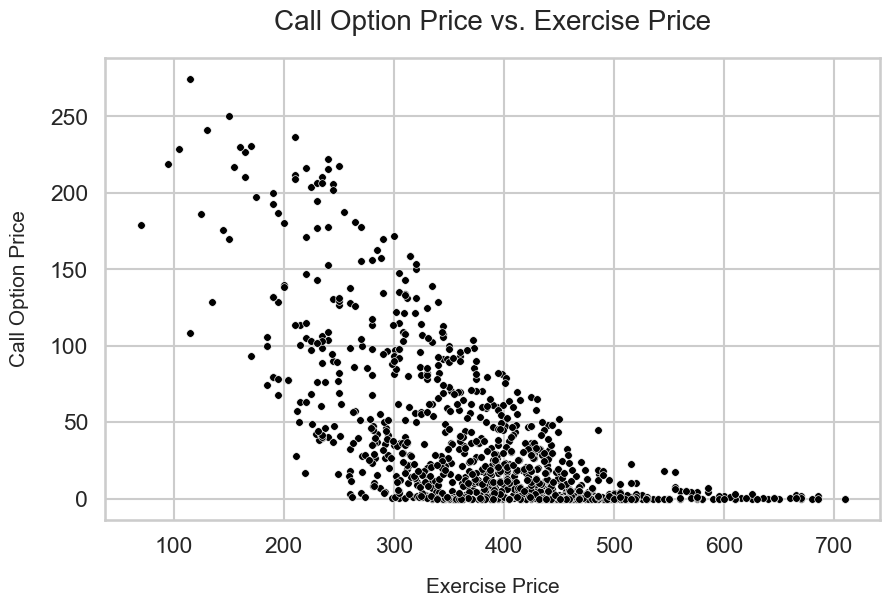

In [91]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Exercise Price", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Exercise Price', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Exercise Price', fontsize=20, pad=20)
plt.show()

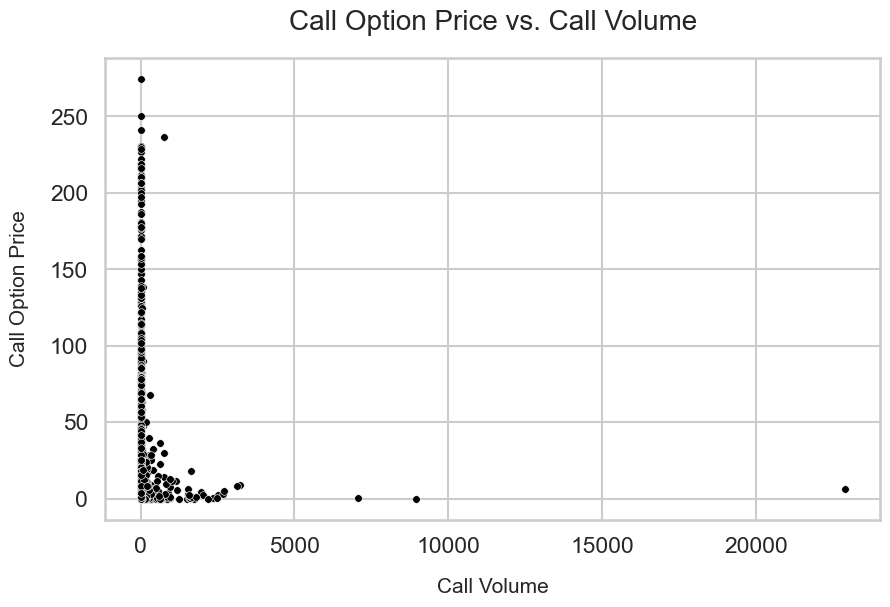

In [92]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Call Volume", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Call Volume', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Call Volume', fontsize=20, pad=20)
plt.show()

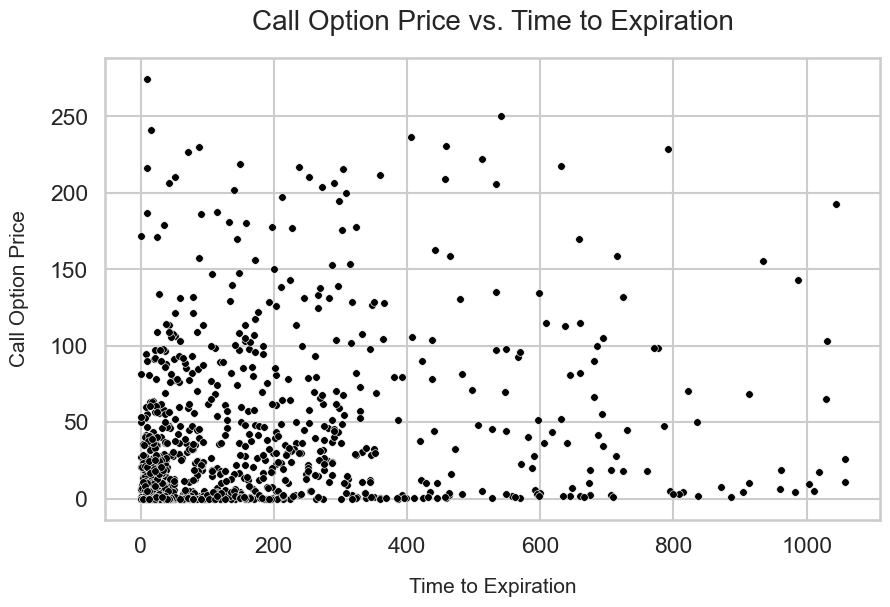

In [93]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Time to Expiration", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Time to Expiration', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Time to Expiration', fontsize=20, pad=20)
plt.show()

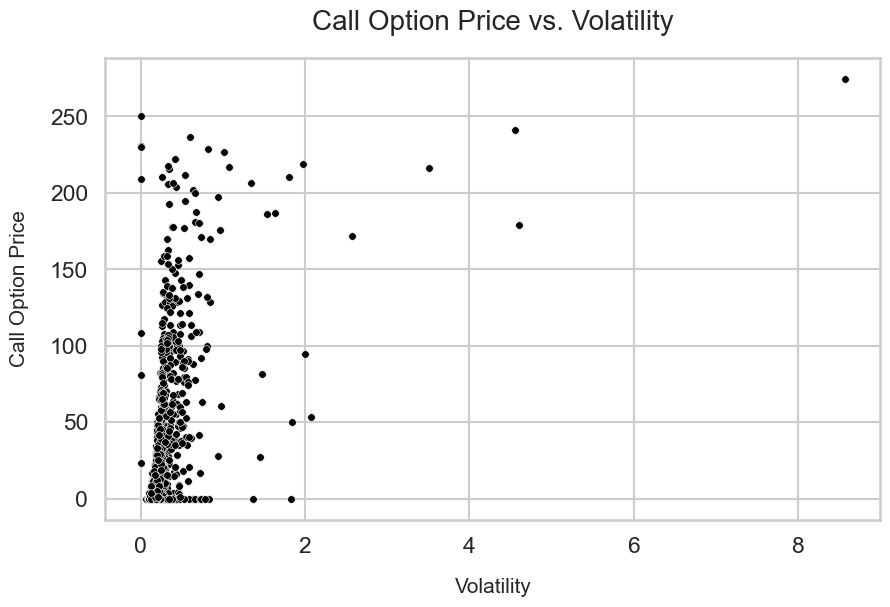

In [94]:
sns.set(style='whitegrid')
sns.set_context("talk")

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Volatility", 
                     y="Call Option Price", 
                     data=data_sample, 
                     color='black', 
                     s=30)

ax.set_xlabel('Volatility', fontsize=15, labelpad=15)
ax.set_ylabel('Call Option Price', fontsize=15, labelpad=15)
ax.set_title('Call Option Price vs. Volatility', fontsize=20, pad=20)
plt.show()

# Linear Model

In [95]:
# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)

[-6.17227468e-06  9.33562642e-01  2.60527494e-04  5.59392286e-03
 -2.44461490e+00]
0.6631277090349457


## LASSO

In [96]:
# Fit LassoCV model to find optimal alpha
lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lasso_cv.fit(X_train, y_train)

LassoCV(cv=10, max_iter=100000)

In [97]:
# Print the optimal alpha value
print("Optimal Alpha Value: ", lasso_cv.alpha_)

Optimal Alpha Value:  7.432874029842656


In [98]:
# Fit LASSO model with optimal alpha
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)
print(lasso.coef_)
print(lasso.intercept_)

[-3.09753197e-06  9.21648756e-01 -0.00000000e+00  6.66138076e-03
 -0.00000000e+00]
0.2807344391616695


## Evaluation & Diagnostics

In [99]:
# Predict on test data
y_pred_full = model.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

# Calculate residuals
residuals_full = y_test - y_pred_full
residuals_lasso = y_test - y_pred_lasso

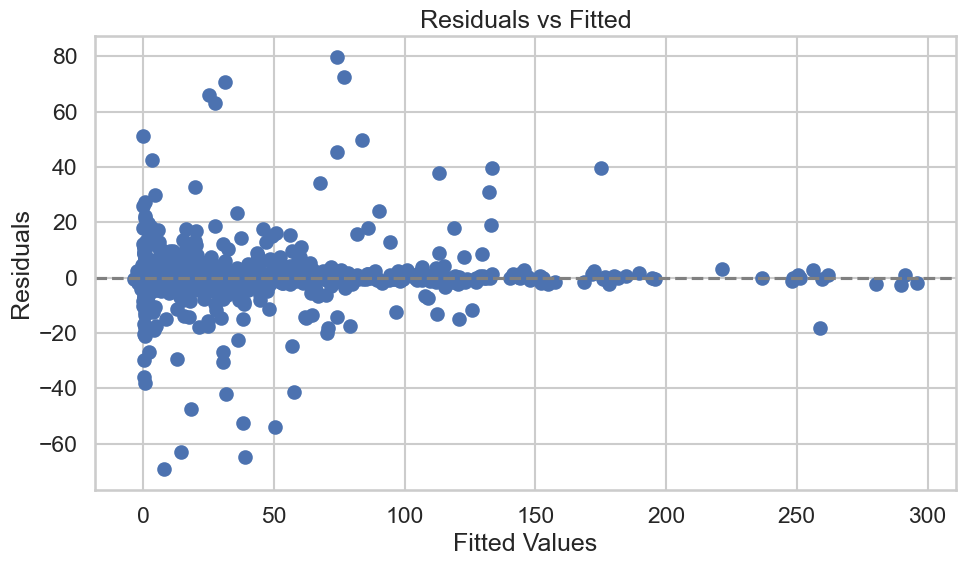

In [100]:
# Plot the residuals
sns.set(style='whitegrid')
sns.set_context("talk")
sns.set_theme
plt.figure(figsize=(10, 6))

plt.scatter(np.random.choice(y_pred_full, 1000, replace=False), np.random.choice(residuals_full, 1000, replace=False))
plt.axhline(y=0, color='grey', linestyle='dashed')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

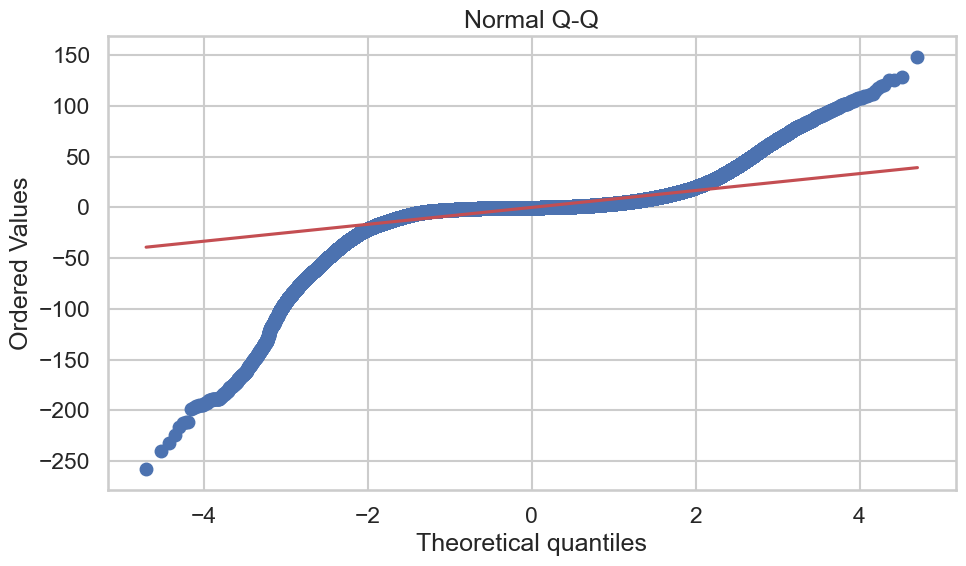

In [101]:
# QQ plot
sns.set(style='whitegrid')
sns.set_context("talk")
sns.set_theme
plt.figure(figsize=(10, 6))

stats.probplot(residuals_full, dist="norm", plot=plt)
plt.title('Normal Q-Q')

plt.tight_layout()
plt.show()

In [104]:
# Assuming model is already fitted
coef = model.coef_
intercept = model.intercept_

# Predicted values
y_pred = model.predict(X_train)

# Residuals
residuals = y_train - y_pred

# Degrees of freedom of residuals
df_residuals = len(y_train) - len(coef) - 1

# Residual standard error
RSE = np.sqrt(np.sum(residuals**2) / df_residuals)

# Standard error of coefficients
SE_coef = RSE / np.sqrt(np.sum((X_train - np.mean(X_train))**2))

# t-statistic for each coefficient
t_stat = coef[0] / SE_coef[0]

# Two-sided p-value for t-statistics
p_value = stats.t.sf(np.abs(t_stat), df_residuals)*2

print('t-statistic:', t_stat)
print('Degrees of freedom:', df_residuals)
print('p-value:', p_value)

t-statistic: -2.6223382617368474
Degrees of freedom: 2201292
p-value: 0.008732930836199982


In [103]:
SE_coef

Call Volume           0.000002
Call Bid Price        0.000053
Exercise Price        0.000030
Time to Expiration    0.000035
Volatility            0.000044
dtype: float64